# Ciphix Machine Learning Case
By: Sander Boers

The objective is to obtain 10 topics from past conversations. A `.csv` file is given with 2,000,000 unlabeled messages. So a unsupervised Machine Learning technique has to be applied. After doing some research I found that this kind of problem is called 'Topic modeling' and that a particular technique called Latent Dirichlet Allocation (LDA) is currently the most popular one.

In the following cells below, I explain my steps with corresponding code.

## Load dataset
There is an option to shrink the dataset to have shorter runtime. Add the following code to end of `pd.read_csv`:
1. `.head(n=10000)` for the first n rows, or
2. `.sample(n=10000)` if you want a random sample.

Also there is the option to only fit to the customer data (`ONLY_CUSTOMERS = True`) and not the replies of particular companies. It checks if a datarow has an `@123456` (or any other numeric combination) inside, this implies a response to a customer and often does not give additional information.

In [13]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Dataset will be downloaded if it is not already there
if os.path.exists('data.csv'):
    data = pd.read_csv('data.csv', names=['text']).head(n=10000)
else:
    data = pd.read_csv('https://ciphix.io/ai/data.csv', names=['text'])


ONLY_CUSTOMERS = True
if ONLY_CUSTOMERS:
    filter = data['text'].str.contains(r'@([0-9]+)')
    data = data[~filter]

## Preprocessing data
This is an important step in Topic modeling. It consists out of multiple processes, the first is removing information we do not need. This includes:
1. URLs, 
2. mentions (words starting with '@'), 
3. the customer service employee signature (e.g. ^JK),
4. any symbols, emojis or non-western characters

Next, all words are put into lowercase and will be tokenized, meaning that all sentences will be split into words.

Then, there are three remaining steps:
We look for bigrams and trigrams, these are words that frequently occur together and will be appended to one word (e.g. 'customer', 'service' will become 'customer_service').
Also stopwords will be removed, stopwords do not contribute much to the meaning of a sentence. Stopwords are for example: 'only', 'would', 'some', 'everyone'.

And finally words will be lemmatized. This step will convert words to its base form, so for example: 'dogs' becomes 'dog' and 'tried' becomes 'try'.


In [14]:
import re
import spacy
import gensim

nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]

def preprocess(doc):
  # Regex to remove URLs
  doc = re.sub(r'\bhttps?://\S+\b', '', doc) 

  # Regex to remove mentions, e.g. @UberSupport
  # doc = re.sub(r'@\w+\b', '', doc) 

  # Regex to remove signatures starting with ('^', '-' or '*')
  doc = re.sub(r'\B[-^*&]\s*\w+', '', doc) 
  
  # Regex to remove any symbols, emojis or non-western characters
  doc = re.sub(r'[^a-zA-Z0-9\s,.?!;:()]+', '', doc) 
  
  # Function to convert document into lowercase, de-accents and tokenize
  doc = gensim.utils.simple_preprocess(doc, deacc=True, min_len=2)

  return doc
  

data['preprocessed_text'] = data['text'].apply(preprocess)

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data['preprocessed_text'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data['preprocessed_text']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


stopwords = nlp.Defaults.stop_words
stopwords.update(["hi", "hello", "hey", "et", "ill"])

def apply_trigrams(doc):
  doc = [token for token in doc if token not in stopwords]
  doc = trigram_mod[bigram_mod[doc]]
  return doc

data['trigram_text'] = data['preprocessed_text'].apply(apply_trigrams)
data = data[data['trigram_text'].apply(len) > 2]


In [16]:
def apply_lemmatization(doc):
  doc = nlp(" ".join(doc))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token) > 2]
  return doc

data['lemmatization_text'] = data['trigram_text'].apply(apply_lemmatization)

In [17]:
from gensim.corpora import Dictionary

dictionary = Dictionary(data['lemmatization_text'])
corpus = [dictionary.doc2bow(doc) for doc in data['lemmatization_text']]

## Fit the dataset to LDA model
Now the model will be trained using the gensim library

In [18]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus = corpus, 
                     id2word = dictionary, 
                     num_topics = 10, 
                     passes = 10)

## Visualization and evaluation
Hereby I show three ways of visualizing the 10 different topics.
1. The first one is the simplest, it prints the topics with their associate words
2. This one uses the `pyLDAvis` library and gives an interactive plot of the topics.
3. The last one generates 10 matplotlib wordclouds, showing the corresponding words. These wordclouds are also used in the webapp.

The evaluation is done with human judgement, quantitative metrics could also been used, but due to time constraints I did not research this field.



In [19]:
for topic_id in range(10):
    print(f'Topic {topic_id}: {lda_model.print_topic(topic_id)}')

Topic 0: 0.093*"chipotletweet" + 0.025*"get" + 0.016*"costume" + 0.016*"today" + 0.015*"boorito" + 0.013*"thank" + 0.012*"day" + 0.011*"burrito" + 0.011*"halloween" + 0.010*"go"
Topic 1: 0.018*"update" + 0.018*"help" + 0.017*"iphone" + 0.017*"chipotletweet" + 0.012*"card" + 0.011*"need" + 0.010*"refund" + 0.010*"coxhelp" + 0.010*"go" + 0.010*"askebay"
Topic 2: 0.028*"flight" + 0.024*"applesupport" + 0.021*"thank" + 0.018*"americanair" + 0.013*"hour" + 0.012*"work" + 0.010*"new" + 0.009*"go" + 0.009*"minute" + 0.008*"britishairway"
Topic 3: 0.020*"know" + 0.019*"askplaystation" + 0.017*"let" + 0.016*"try" + 0.015*"microsofthelp" + 0.012*"game" + 0.010*"think" + 0.010*"thank" + 0.010*"help" + 0.009*"problem"
Topic 4: 0.040*"order" + 0.013*"late" + 0.012*"bad" + 0.012*"thank" + 0.011*"hour" + 0.011*"flight" + 0.011*"change" + 0.010*"day" + 0.010*"americanair" + 0.010*"update"
Topic 5: 0.014*"watch" + 0.014*"add" + 0.014*"live" + 0.012*"time" + 0.011*"hulusupport" + 0.009*"sprintcare" + 0.

In [20]:
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualize with pyLDAvis: See [2] for more details
pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim_models.prepare(
    lda_model, 
    corpus,
    dictionary, 
    mds = "mmds", 
    R = 30)

visualization

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.037074  0.049753       1        1  13.240604
0      0.019510 -0.258507       2        1  12.321030
7     -0.192812 -0.058439       3        1  12.291652
8     -0.120909  0.182684       4        1  11.788156
3      0.220475 -0.170494       5        1   9.635040
4      0.183796 -0.030792       6        1   8.713241
6      0.043099  0.260936       7        1   8.463772
9     -0.163810 -0.221382       8        1   8.348006
1     -0.262180  0.082793       9        1   7.756652
5      0.235759  0.163447      10        1   7.441847, topic_info=              Term        Freq       Total Category  logprob  loglift
87   chipotletweet  361.000000  361.000000  Default  30.0000  30.0000
598    spotifycare   87.000000   87.000000  Default  29.0000  29.0000
132          order  119.000000  119.000000  Default  28.0000  28.0000
53            help  177.000000  177.000000  Default  27.0000  27.0000
349         flight  143.000000  143.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
171           game    9.901761   61.229260  Topic10  -5.1320   0.7761
124          issue   10.433493  100.568971  Topic10  -5.0797   0.3322
668    americanair   10.342450  100.729905  Topic10  -5.0884   0.3219
27            need    9.572550  116.764226  Topic10  -5.1658   0.0968
349         flight    9.475818  143.242696  Topic10  -5.1759  -0.1177

[675 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
22        3  0.469107  account
22        4  0.392518  account
22        5  0.019147  account
22        7  0.076589  account
22       10  0.038294  account
...     ...       ...      ...
150       4  0.078566     year
150       5  0.026189     year
150       7  0.157132     year
150       9  0.157132     year
2465      6  0.780587     zone

[1361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 8, 9, 4, 5, 7, 10, 2, 6])

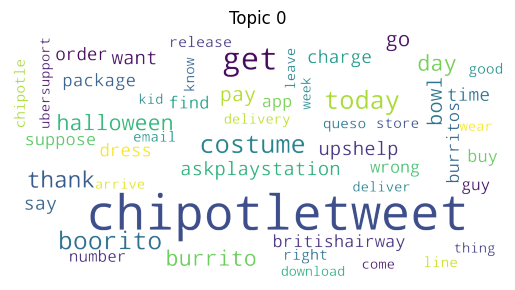

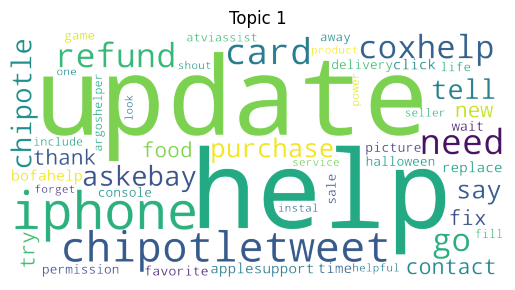

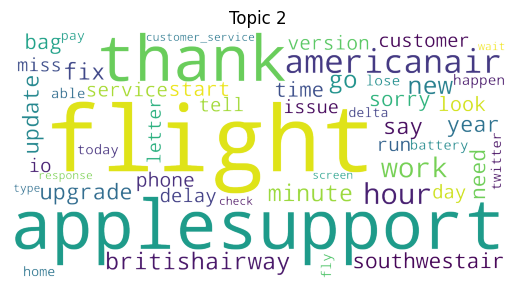

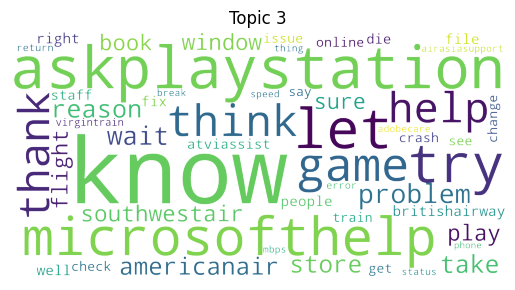

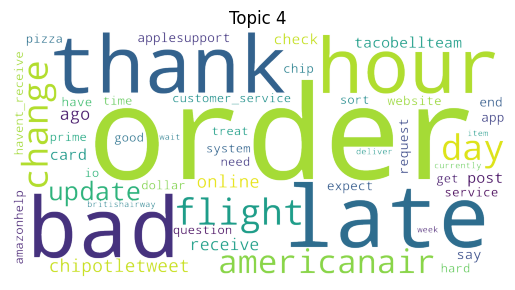

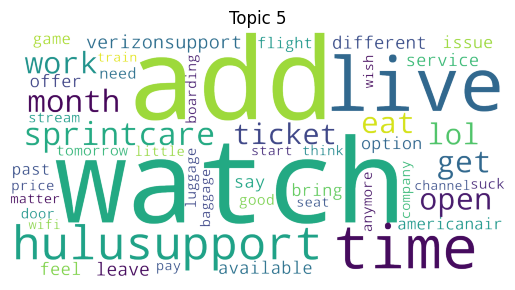

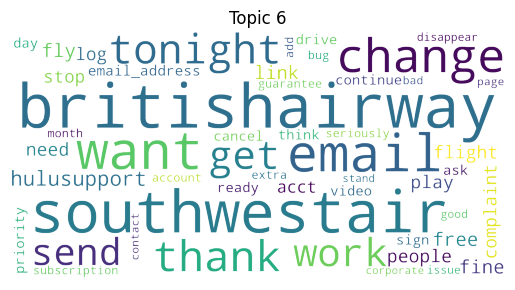

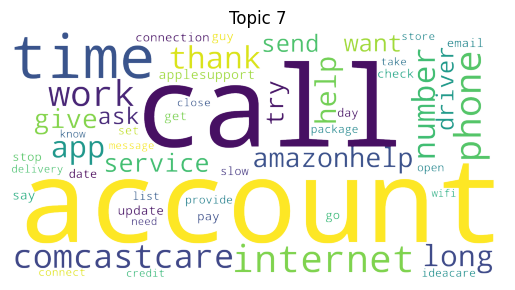

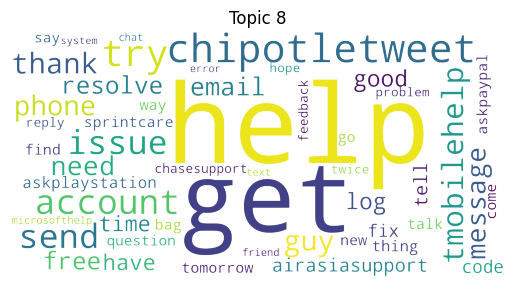

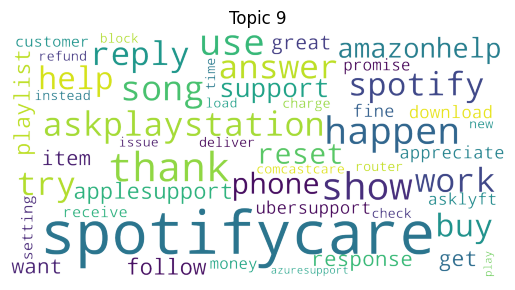

In [21]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

for t in range(lda_model.num_topics):
    plt.figure()
    plt.gca().set_title('Topic ' + str(t))
    plt.imshow(WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", width=1600, height=800).fit_words(dict(lda_model.show_topic(t, 50))))
    plt.axis("off")
    plt.gcf().savefig(f"./static/wordclouds/topic{t}.png", transparent=True, dpi=300)
    plt.show()


## Saving models
The final step in this notebook is saving the models to be used in the webapp.

In [22]:
# Save models
lda_model.save('./saved_models/LDAmodel')
bigram_mod.save("./saved_models/bigram_mod.pkl")
trigram_mod.save("./saved_models/trigram_mod.pkl")


## Discussion
The trained model is not perfect. It could definitely be improved. Here a few adjustments I could think of that might improve the model.
1. Do more research in the effect of excluding the companies replies.
2. In the preprocessing step, there is a commented line that would remove mentions (like @applesupport).
3. By using pandas dataframe, I could easily see the preprocessing steps. Here I found some strange conversations by the lemmatization step. Like removing certain important words.
4. I added the bigram and trigram step, but have never seen these in the wordclouds.
5. Try another ML model, instead of Latent Dirichlet Allocation (LDA). See Markdown cell below.

# Other Topic Modeling techniques
As mentioned I used the Latent Dirichlet Allocation (LDA) method for this case. However, there are other ways of modeling topics. To mention a few:
1. Latent Semantic Analysis (LSA)
2. Non-Negative Matrix factorization (NNMF)
3. Probabilistic Latent Semantic Analysis (PLSA)
4. Transformer-based model BERTopic

Especially the last one seems interesting.
This [notebook](https://colab.research.google.com/drive/1jhP3-UV0DCCh0JvFYv_8Pwsz1PQ-TkFo?usp=sharing#scrollTo=Dk2qV08ZERD5) seem to describe this method quite easily.